In [ ]:
!pip install transformers datasets sentencepiece

###  Importing the required libarires

In [1]:
import torch
from datasets import load_dataset
from tqdm import tqdm
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, SequentialSampler
from sklearn.metrics import matthews_corrcoef
from transformers import (AdamW,T5ForConditionalGeneration,T5Tokenizer,get_linear_schedule_with_warmup)

In [3]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid.
Your token has been saved to /root/.cache/huggingface/token
Login successful


###  Loading the dataset

In [2]:
dataset = load_dataset('glue', 'stsb')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

Found cached dataset glue (C:/Users/NIT/.cache/huggingface/datasets/glue/stsb/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

device(type='cuda')

### Loading the tokenizer and pre-trained model

In [10]:
tokenizer = T5Tokenizer.from_pretrained("t5-base")
model = T5ForConditionalGeneration.from_pretrained("t5-base")
model.to(device)
print('Loaded Model')

Loaded Model


In [11]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("PavanNeerudu/t5-base-finetuned-stsb")

fineTunedModel = AutoModelForSeq2SeqLM.from_pretrained("PavanNeerudu/t5-base-finetuned-stsb")
fineTunedModel.cuda()
print('loaded model and tokenizer')

loaded model and tokenizer


### Forming the train, validaton and test loaders

In [12]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, SequentialSampler

def round_to_nearest_0_2(num):
    return round(num * 5) / 5

def getDataLoader(input):
    inputs = ["stsb sentence1: " + doc1 + " sentence2: "+ doc2 for doc1, doc2 in zip(input['sentence1'], input['sentence2'])]
    #tokenized_inputs = tokenizer.batch_encode_plus(inputs, max_length = 256, pad_to_max_length=True, return_tensors = "pt")
    tokenized_inputs = tokenizer(inputs, padding = True, return_tensors="pt")
    source_ids = tokenized_inputs['input_ids']
    source_mask = tokenized_inputs['attention_mask']
    
    targets = [str(round_to_nearest_0_2(label)) for label in input['label']]
    tokenized_outputs = tokenizer(targets, padding = True, return_tensors="pt")
    target_ids = tokenized_outputs['input_ids']
    target_mask = tokenized_outputs['attention_mask']

    # Create a TensorDataset
    batch_size = 32
    data = TensorDataset(source_ids, source_mask, target_ids, target_mask)

    # Create a data loader
    sampler = SequentialSampler(data)
    return DataLoader(data, sampler = sampler, batch_size=batch_size)

train_dataloader = getDataLoader(dataset['train'])
validation_dataloader = getDataLoader(dataset['validation'])
test_dataloader = getDataLoader(dataset['test'])

In [14]:
no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {
        "params": [
            p
            for n, p in model.named_parameters()
            if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
    {
        "params": [
            p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]
optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-4,
    eps=1e-8,
)


num_epochs = 5
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

### Fine-tuning T5

In [15]:
from scipy import stats
best_pcc = 0
for epoch in range(num_epochs):
    model.train()
    
    total_loss = 0
    for batch in tqdm(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        source_ids, source_mask, lm_labels, target_mask = batch
        lm_labels[lm_labels[:, :] == tokenizer.pad_token_id] = -100

        optimizer.zero_grad()

        outputs = model(
            input_ids=source_ids,
            attention_mask=source_mask,
            labels = lm_labels,
            decoder_attention_mask=target_mask
        )
        
        loss = outputs[0]
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
        scheduler.step()
    
    # Compute the average loss for the epoch
    avg_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch+1}/{num_epochs} - loss: {avg_loss:.4f}')



    # Evaluate the model on the validation set
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in tqdm(validation_dataloader):
            batch = tuple(t.to(device) for t in batch)
            source_ids, source_mask, lm_labels, target_mask = batch
            outs = model.generate(input_ids=source_ids, 
                                  attention_mask=source_mask,
                                  max_length=10)

            predicted_labels = [float(tokenizer.decode(output, skip_special_tokens=True)) for output in outs]
            predictions.extend(predicted_labels)
  
        
    val_pcc,_ = stats.pearsonr(dataset['validation']['label'], predictions)
    print(f'Epoch {epoch+1}/{num_epochs} - validation PCC: {val_pcc:.4f}')
    
    if val_pcc > best_pcc:
        best_pcc = val_pcc
        model.save_pretrained("t5-stsb")

100%|████████████████████████████████████████████████████████████████████████████████| 180/180 [01:39<00:00,  1.81it/s]


Epoch 1/5 - loss: 0.8623


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:07<00:00,  5.92it/s]


Epoch 1/5 - validation PCC: 0.8200


100%|████████████████████████████████████████████████████████████████████████████████| 180/180 [01:38<00:00,  1.84it/s]


Epoch 2/5 - loss: 0.7782


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:07<00:00,  5.99it/s]


Epoch 2/5 - validation PCC: 0.8675


100%|████████████████████████████████████████████████████████████████████████████████| 180/180 [01:36<00:00,  1.86it/s]


Epoch 3/5 - loss: 0.7040


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:07<00:00,  5.99it/s]


Epoch 3/5 - validation PCC: 0.8937


100%|████████████████████████████████████████████████████████████████████████████████| 180/180 [01:36<00:00,  1.86it/s]


Epoch 4/5 - loss: 0.6156


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.01it/s]


Epoch 4/5 - validation PCC: 0.8898


100%|████████████████████████████████████████████████████████████████████████████████| 180/180 [01:36<00:00,  1.87it/s]


Epoch 5/5 - loss: 0.5785


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:07<00:00,  5.96it/s]

Epoch 5/5 - validation PCC: 0.8902


In [16]:
model = T5ForConditionalGeneration.from_pretrained("t5-stsb")
#model.cuda()

In [17]:
!huggingface-cli login

^C


In [24]:
model.push_to_hub("t5-finetuned-stsb")
tokenizer.push_to_hub("t5-finetuned-stsb")

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/PavanNeerudu/t5-finetuned-stsb/commit/463316b000021a834f3827980400b4c0f7bc01c6', commit_message='Upload tokenizer', commit_description='', oid='463316b000021a834f3827980400b4c0f7bc01c6', pr_url=None, pr_revision=None, pr_num=None)

### Obtaining hidden states averaged over all the tokens to get a single representation of 768 tokens

In [5]:
def getHiddenStates(currModel, dataloader):
    currModel.eval()
    totalHiddenStates = [0]*13
    flag = True
    with torch.no_grad():
        for batch in tqdm(dataloader):
            batch = tuple(t.to(device) for t in batch)
            
            source_ids, source_mask, lm_labels, target_mask = batch
            outputs = currModel(input_ids=source_ids,
                            attention_mask=source_mask,
                            labels = lm_labels,
                            decoder_attention_mask=target_mask, 
                            output_hidden_states = True, 
                            return_dict=True)

            hidden_states = outputs.encoder_hidden_states
         
            if flag == True:
                for i in range(len(hidden_states)):
                    totalHiddenStates[i] = hidden_states[i].to("cpu").mean(dim = 1)
                flag = False
            else:
                for i in range(len(hidden_states)):
                    temp = hidden_states[i].to("cpu").mean(dim = 1)
                    totalHiddenStates[i] = torch.cat((totalHiddenStates[i], temp), 0)   
        return totalHiddenStates   


In [8]:
hiddenStates = getHiddenStates(model, test_dataloader)
preTrainedHiddenStates = torch.stack(hiddenStates, dim = 0)
torch.save(preTrainedHiddenStates, 'preTrainedHiddenStates_STS-B.pt')
preTrainedHiddenStates.shape

100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:15<00:00,  2.93it/s]


torch.Size([13, 1379, 768])

In [9]:
hiddenStates = getHiddenStates(fineTunedModel, test_dataloader)
fineTunedHiddenStates = torch.stack(hiddenStates, dim = 0)
torch.save(fineTunedHiddenStates, 'fineTunedHiddenStates_STS-B.pt')
fineTunedHiddenStates.shape

100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:06<00:00,  6.56it/s]


torch.Size([13, 1379, 768])

In [10]:
from CKA import CKA, CudaCKA
cuda_cka = CudaCKA(device)

In [11]:
cka_matrix = torch.empty((13, 13))
for i in range(13):
    for j in range(13):
        X = preTrainedHiddenStates[i].to(device)
        Y = fineTunedHiddenStates[j].to(device)
        cka_matrix[i][j] = cuda_cka.linear_CKA(X, Y)
#torch.save(cka_matrix, 'ckaMatrix.pt')
cka_matrix = cka_matrix.numpy()

In [12]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

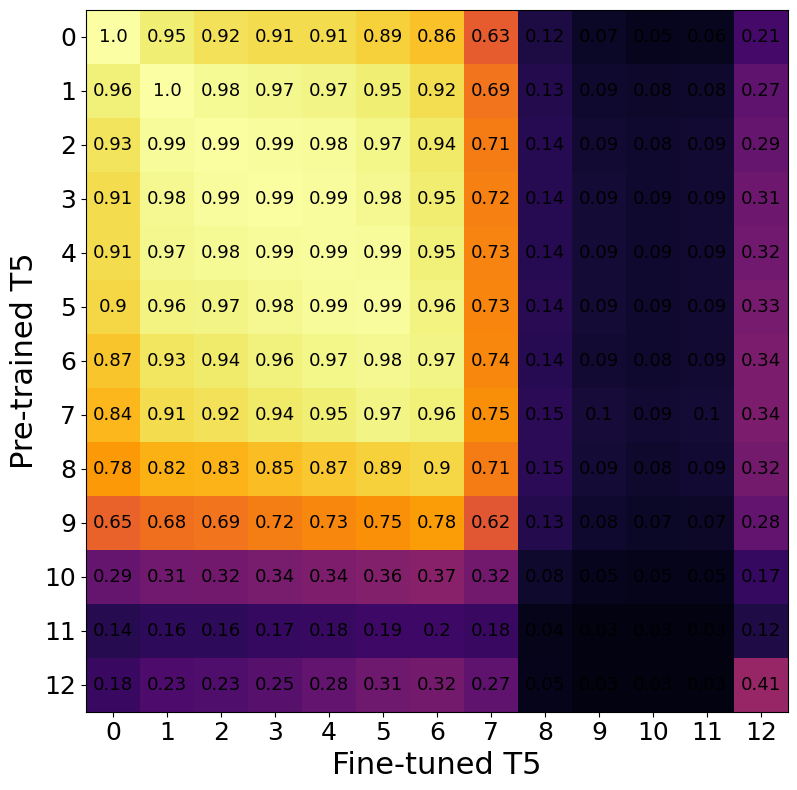

In [13]:
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cka_matrix, cmap="inferno", vmin=0.0, vmax=1.0)

plt.xticks(np.arange(0,13), fontsize = 18)
plt.yticks(np.arange(0,13), fontsize = 18)

cka_matrix = np.round(cka_matrix, 2)
for x in range(13):
    for y in range(13):
        plt.annotate(cka_matrix[x][y], xy=(y, x), horizontalalignment='center', verticalalignment='center', fontsize=13)

plt.ylabel('Pre-trained T5', fontsize = 22)
plt.xlabel('Fine-tuned T5', fontsize = 22)

#fig.colorbar(im)

plt.tight_layout()

#plt.show()

plt.savefig('STS-B_preTrained_fineTuned.pdf',  bbox_inches='tight')
plt.savefig('STS-B_preTrained_fineTuned.jpg',  bbox_inches='tight')

### Calculating STIR

In [14]:
preTrainedHiddenStates = torch.load('./preTrainedHiddenStates_STS-B.pt').to(device)
fineTunedHiddenStates  = torch.load('./fineTunedHiddenStates_STS-B.pt').to(device)
print(preTrainedHiddenStates.shape,fineTunedHiddenStates.shape)

torch.Size([13, 1379, 768]) torch.Size([13, 1379, 768])


In [15]:
distinm1 = []
distinm2 = []
for i in range(13):
    distinm1.append(torch.cdist(preTrainedHiddenStates[i], preTrainedHiddenStates[i]))
    distinm2.append(torch.cdist(fineTunedHiddenStates[i], fineTunedHiddenStates[i]))

In [16]:
for i in range(13):
    for j in range(distinm1[0].shape[0]):
        distinm1[i][j][j] = 100000.0
        distinm2[i][j][j] = 100000.0

In [17]:
num_rows = preTrainedHiddenStates.shape[1]
minDistIndForm1 = []
for i in range(13):
    temp = []
    for j in range(num_rows):
        temp.append(torch.argmin(distinm1[i][j]))
    minDistIndForm1.append(temp)
    
minDistIndForm2 = []
for i in range(13):
    temp = []
    for j in range(num_rows):
        temp.append(torch.argmin(distinm2[i][j]))
    minDistIndForm2.append(temp)

In [18]:
from CKA import CKA, CudaCKA
cuda_cka = CudaCKA(device)

In [19]:
import random
def calculate(noOfSamples, noOfTimes):
    STIRm2m1 = []
    STIRm1m2 = []
    CKA = []
    for i in range(13):
        stirm2m1 = 0
        stirm1m2 = 0
        cka = 0
        for j in range(noOfTimes):
            num_list = random.sample(range(0, num_rows), noOfSamples)
            X = []
            X_ = []
            Y = []
            Y_ = []
            for k in range(len(num_list)):
                X.append(fineTunedHiddenStates[i][num_list[k]])
                X_.append(fineTunedHiddenStates[i][minDistIndForm1[i][num_list[k]]])
                Y.append(preTrainedHiddenStates[i][num_list[k]])
                Y_.append(preTrainedHiddenStates[i][minDistIndForm2[i][num_list[k]]])
                
            X = torch.stack(X, dim = 0)
            X_ = torch.stack(X_, dim = 0)
            Y = torch.stack(Y, dim = 0)
            Y_ = torch.stack(Y_, dim = 0)
            
            stirm2m1 = stirm2m1 + cuda_cka.linear_CKA(X, X_)
            stirm1m2 = stirm1m2 + cuda_cka.linear_CKA(Y, Y_)
            cka = cka + cuda_cka.linear_CKA(Y, X)
        
        STIRm2m1.append(stirm2m1/noOfTimes)
        STIRm1m2.append(stirm1m2/noOfTimes)
        CKA.append(cka/noOfTimes)
    return STIRm2m1, STIRm1m2, CKA

In [20]:
STIRm2m1, STIRm1m2, CKA = calculate(num_rows//2, 20)

In [21]:
STIRm2m1 = torch.stack(STIRm2m1, dim = 0)
STIRm1m2 = torch.stack(STIRm1m2,dim = 0)
CKA = torch.stack(CKA, dim = 0)

In [22]:
STIRm2m1 = STIRm2m1.to("cpu")
STIRm2m1 = STIRm2m1.numpy()
STIRm1m2 = STIRm1m2.to("cpu")
STIRm1m2 = STIRm1m2.numpy()
CKA = CKA .to("cpu")
CKA = CKA .numpy()

In [23]:
print('STIRm2m1:', STIRm2m1)
print('STIRm1m2:', STIRm1m2)
print('CKA:', CKA)

STIRm2m1: [0.995815   0.9678035  0.95412266 0.94651765 0.94052106 0.9296679
 0.9082677  0.67812896 0.32723683 0.26319364 0.24870773 0.19647823
 0.47398463]
STIRm1m2: [0.9958133  0.9693653  0.96047735 0.95476025 0.94681257 0.9350376
 0.9289166  0.9156726  0.85589707 0.7262805  0.38549086 0.34826335
 0.70790666]
CKA: [1.         0.99898    0.9941851  0.99290097 0.991809   0.98999757
 0.9644849  0.7541903  0.15081783 0.08198683 0.04753713 0.03377527
 0.4094347 ]


In [24]:
import numpy as np
print('STIRm2m1: ', np.round(STIRm2m1, 2))
print('STIRm1m2: ', np.round(STIRm1m2, 2))
print('CKA: ', np.round(CKA, 2))

STIRm2m1:  [1.   0.97 0.95 0.95 0.94 0.93 0.91 0.68 0.33 0.26 0.25 0.2  0.47]
STIRm1m2:  [1.   0.97 0.96 0.95 0.95 0.94 0.93 0.92 0.86 0.73 0.39 0.35 0.71]
CKA:  [1.   1.   0.99 0.99 0.99 0.99 0.96 0.75 0.15 0.08 0.05 0.03 0.41]


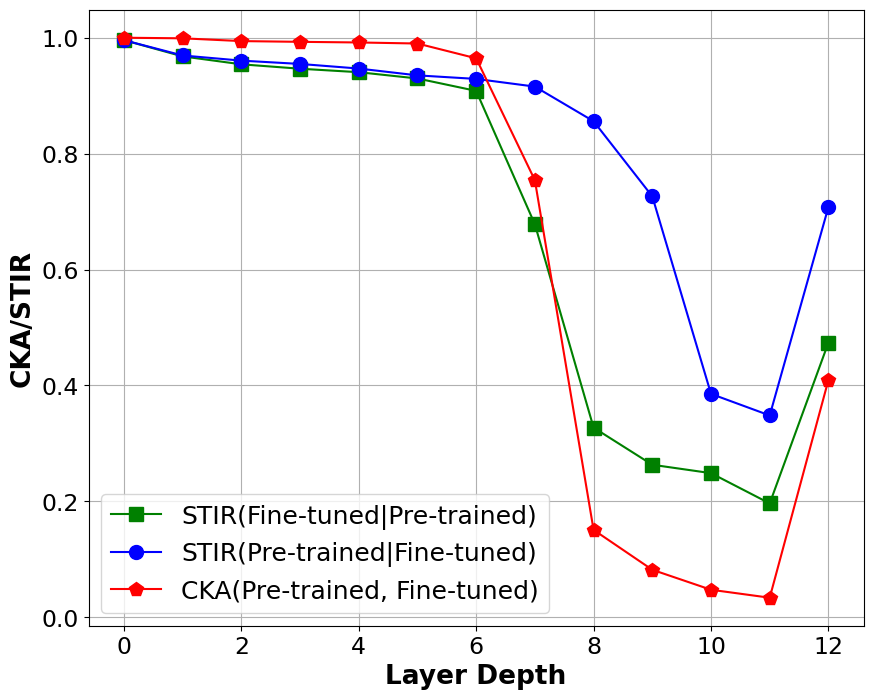

In [25]:
import numpy as np
import matplotlib.pyplot as plt

xs = np.arange(13)
plt.rcParams["figure.figsize"] = [10,8]

series = np.array(STIRm2m1)
smask = np.isfinite(series)
plt.plot(xs[smask], series[smask], linestyle='-', marker='s', markersize=10, color='green')

series = np.array(STIRm1m2)
smask = np.isfinite(series)
plt.plot(xs[smask], series[smask], linestyle='-', marker='o', markersize=10, color='blue')

series = np.array(CKA)
smask = np.isfinite(series)
plt.plot(xs[smask], series[smask], linestyle='-', marker='p', markersize=10, color='red')

plt.legend(['STIR(Fine-tuned|Pre-trained)', 'STIR(Pre-trained|Fine-tuned)', 'CKA(Pre-trained, Fine-tuned)'], fontsize=18)
plt.xlabel('Layer Depth', fontsize = 19, fontweight = 'bold')
plt.ylabel('CKA/STIR', fontsize = 19, fontweight ='bold')

plt.grid(True)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
#plt.tight_layout()
#plt.show()
plt.savefig('STS-B CKA STIR.pdf', bbox_inches='tight')
plt.savefig('STS-B CKA STIR.jpg', bbox_inches='tight')

In [7]:
def test(dataloader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            batch = tuple(t.to(device) for t in batch)
            source_ids, source_mask, lm_labels, target_mask = batch
            outs = model.generate(input_ids=source_ids, 
                                  attention_mask=source_mask,
                                  max_length=3)

            predicted_labels = [float(tokenizer.decode(output, skip_special_tokens=True)) for output in outs]
            predictions.extend(predicted_labels)
    return predictions

In [8]:
import pandas as pd
predictions = test(test_dataloader)
filename = '../Original/STS-B.tsv'
result = pd.DataFrame(predictions, columns=['prediction'])
result.insert(0, 'index', range(0, len(result)))
result.to_csv(filename, sep='\t', index=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:09<00:00,  4.47it/s]


In [12]:
def test2(dataloader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            batch = tuple(t.to(device) for t in batch)
            source_ids, source_mask = batch
            outs = model.generate(input_ids=source_ids, 
                                  attention_mask=source_mask,
                                  max_length=3)

            predicted_labels = [float(tokenizer.decode(output, skip_special_tokens=True)) for output in outs]
            predictions.extend(predicted_labels)
    return predictions

In [27]:
def getModifiedDataLoader(ts1, ts2):
    inputs = ["stsb sentence1: " + doc1 + " sentence2: "+ doc2 for doc1, doc2 in zip(ts1, ts2)]
    tokenized_inputs = tokenizer(inputs, padding = True, return_tensors="pt")
    source_ids = tokenized_inputs['input_ids']
    source_mask = tokenized_inputs['attention_mask']

    # Create a TensorDataset
    batch_size = 8
    data = TensorDataset(source_ids, source_mask)

    # Create a data loader
    sampler = SequentialSampler(data)
    return DataLoader(data, sampler = sampler, batch_size=batch_size)



test_dataloader = getModifiedDataLoader(test_sentence1, test_sentence2)
predictions = test2(test_dataloader)
filename = '../bias/STS-B.tsv'
result = pd.DataFrame(predictions, columns=['prediction'])
result.insert(0, 'index', range(0, len(result)))
result.to_csv(filename, sep='\t', index=False)

100%|████████████████████████████████████████████████████████████████████████████████| 173/173 [00:13<00:00, 13.06it/s]
